# Donkey Car Dataset Diversification

## Notebook Context

This notebook focuses on the impact of diverse datasets (Not more data, not enough ram yet - will think of a way to compress the images like they did with the CIFAR-10 dataset) on model performance. 

Data will be randomly extracted from three pools - the generated track set, the generated road set, and the warehouse set. The model is then trained with this diverse dataset and tested on each of these three environments as was done with the baseline establishment testing loop. This will probably only show that if the model has seen it before, it will perform on it again. 

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


### Step 1: Dataset Retrieval and Management
The Dataset used for this experiment is found in the mounted Google Drive folder (if not mounted, contact me and we can try sort it out). The dataset consists of images, and json labels for those images. The json labels contain the driving angle as floating point values in the range of -1 and 1. -1 means all the way left, and 1 means all the way to the right. We are not addressing throttle labels in this experiment. 


In [3]:
!mkdir ./AllCombo
#Mount Data Folder From Google Drive: - this could be split into train/test sets?
path0 = "./GenTrack5Throttle/"
path1 = "./DefRoad5Throttle/"
path2 = "./WH5Throttle/"
path = "./AllCombo/"


In [ ]:
!unzip '/content/drive/My Drive/DIYRobocars_2020/Data/DonkeyGymData_Jul2020/GenTrack5Throttle.zip'
!unzip '/content/drive/My Drive/DIYRobocars_2020/Data/DonkeyGymData_Jul2020/WH5Throttle.zip'
!unzip '/content/drive/My Drive/DIYRobocars_2020/Data/DonkeyGymData_Jul2020/DefRoad5Throttle.zip'

Archive:  /content/drive/My Drive/DIYRobocars_2020/Data/DonkeyGymData_Jul2020/GenTrack5Throttle.zip
replace GenTrack5Throttle/0_cam-image_array_.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: Archive:  /content/drive/My Drive/DIYRobocars_2020/Data/DonkeyGymData_Jul2020/WH5Throttle.zip
replace WH5Throttle/0_cam-image_array_.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
#Import required packages for this step:
%tensorflow_version 1.x
import os   #For retrieving files
import natsort #For sorting retrieved files
import numpy as np #Calculations, arrays, etc.
import cv2 #Image preprocessing, loading and saving images
import json #For processing json files
import tensorflow as tf  #For the ML side
from random import randrange 

import matplotlib.pyplot as plt #Plots


#Make sure plots happen inline


%matplotlib inline

TensorFlow 1.x selected.


In [ ]:
def Combinatorix(data_list, label_list, shuffle=True, comp_size = 1.0):

    assert shuffle
    data_list = list(data_list)
    label_list = list(label_list)
    labels_master = []
    data_master = []

    target_combo_size = len(data_list) * (comp_size)

    i_sample = 0

    while i_sample < target_combo_size and len(data_list) > 1:
        i_choice = np.random.randint(0, len(data_list) - 1)
        data_master.append(data_list.pop(i_choice))
        labels_master.append(label_list.pop(i_choice))
        i_sample += 1

    return data_master, labels_master


def MasterTrainTest(data_list, label_list, shuffle=True, test_split = 0.3):
  
    assert shuffle
    data_list = list(data_list)
    label_list = list(label_list)
    test_labels = []
    test_data = []

    target_test_size = len(data_list) * (test_split)
  
    i_sample = 0
    while i_sample < target_test_size and len(data_list) > 1:
        i_choice = np.random.randint(0, len(data_list) - 1)
        test_data.append(data_list.pop(i_choice))
        test_labels.append(label_list.pop(i_choice))
        i_sample += 1

    return data_list, label_list, test_data, test_labels

In [ ]:
#CombinationData Script - Combine Data into train/test arrays directly from three different paths.
#Read data from files into corresponding lists
%%time
import shutil
im_list = [] #initialise list of images

rec_list = [] #initialise list of records

im0_list = [] #initialise list of images

rec0_list = [] #initialise list of records


im1_list = [] #initialise list of images

rec1_list = [] #initialise list of records

im2_list = [] #initialise list of images

rec2_list = [] #initialise list of records
#Read relevant files into relevant lists

i = 0

for file in os.listdir(path0):
    i+= 1
    if 'cam' in file:
        im0_list.append(str(i)+"_cam-image_array_.jpg")
        shutil.copy(path0+file, path+str(i)+"_cam-image_array_.jpg", follow_symlinks=True)
    elif 'record' in file:
        rec0_list.append("record_"+str(i)+".json")
        shutil.copy(path0+file, path+"record_"+str(i)+".json", follow_symlinks=True)

im0_list.sort(key=lambda f: int(''.join(filter(str.isdigit, f))))
rec0_list.sort(key=lambda f: int(''.join(filter(str.isdigit, f))))
im0_list, rec0_list, test_data0, test_labels0 = MasterTrainTest(im0_list, rec0_list)

im_list.extend(im0_list)
rec_list.extend(rec0_list)

for file in os.listdir(path1):
    i+= 1
    if 'cam' in file:
        im1_list.append(str(i)+"_cam-image_array_.jpg")
        shutil.copy(path1+file, path+str(i)+"_cam-image_array_.jpg", follow_symlinks=True)
    elif 'record' in file:
        rec1_list.append("record_"+str(i)+".json")
        shutil.copy(path1+file, path+"record_"+str(i)+".json", follow_symlinks=True)
im1_list.sort(key=lambda f: int(''.join(filter(str.isdigit, f))))
rec1_list.sort(key=lambda f: int(''.join(filter(str.isdigit, f))))
im1_list, rec1_list, test_data1, test_labels1 = MasterTrainTest(im1_list, rec1_list)

im_list.extend(im1_list)
rec_list.extend(rec1_list)

for file in os.listdir(path2):
    i+=1
    if 'cam' in file:
        im2_list.append(str(i)+"_cam-image_array_.jpg")
        shutil.copy(path2+file, path+str(i)+"_cam-image_array_.jpg", follow_symlinks=True)
    elif 'record' in file:
        rec2_list.append("record_"+str(i)+".json")
        shutil.copy(path2+file, path+"record_"+str(i)+".json", follow_symlinks=True)
im2_list.sort(key=lambda f: int(''.join(filter(str.isdigit, f))))
rec2_list.sort(key=lambda f: int(''.join(filter(str.isdigit, f))))
im2_list, rec2_list, test_data2, test_labels2 = MasterTrainTest(im2_list, rec2_list)
im_list.extend(im2_list)
rec_list.extend(rec2_list)
print(len(im_list))
print(len(rec_list))
train_data, train_labels = Combinatorix(im_list, rec_list)

32308
32308
CPU times: user 5.85 s, sys: 7.07 s, total: 12.9 s
Wall time: 13.1 s


In [ ]:
#Donkey Training and Val data splits
def train_test_split(data_list,label_list, label2_list, shuffle=True, test_size=0.2):
    '''
    take a list, split it into two sets while selecting a 
    random element in order to shuffle the results.
    use the test_size to choose the split percent.
    shuffle is always True, left there to be backwards compatible
    '''
    assert shuffle
    data_list = list(data_list)
    label_list = list(label_list)
    label2_list = list(label2_list)
    train_data = []
    traina_labels =[]
    traint_labels =[]

    target_train_size = len(data_list) * (1. - test_size)

    i_sample = 0

    while i_sample < target_train_size and len(data_list) > 1:
        i_choice = np.random.randint(0, len(data_list) - 1)
        train_data.append(data_list.pop(i_choice))
        traina_labels.append(label_list.pop(i_choice))
        traint_labels.append(label2_list.pop(i_choice))
        i_sample += 1

    # remainder of the original list is the validation set
    val_data = data_list
    vala_labels = label_list
    valt_labels = label2_list
    del data_list
    del label_list
    del label2_list
    return val_data, train_data, vala_labels, traina_labels, valt_labels, traint_labels

0.2296077
0.05
(25846, 120, 160, 3)


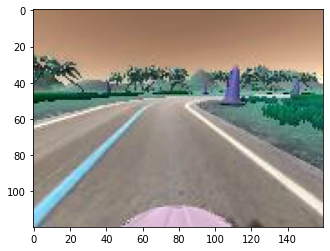

In [ ]:
#Directly reading data into val data split to save RAM

width = 120 #set image width
height = 160 #set image height
color = 3  #set colour channels
dim = (width, height) #Create dimension tuple

train_data.sort(key=lambda f: int(''.join(filter(str.isdigit, f))))
train_labels.sort(key=lambda f: int(''.join(filter(str.isdigit, f))))

x_vallist, x_trainlist, y_valalist, y_trainalist, y_valtlist, y_traintlist = train_test_split(train_data,train_labels,train_labels)

#x_vallist.sort(key=lambda f: int(''.join(filter(str.isdigit, f)))) #Sort by filename number
#x_trainlist.sort(key=lambda f: int(''.join(filter(str.isdigit, f)))) #sort by filename number

#y_valalist.sort(key=lambda f: int(''.join(filter(str.isdigit, f)))) #Sort by filename number
#y_trainalist.sort(key=lambda f: int(''.join(filter(str.isdigit, f)))) #sort by filename number

#y_valtlist.sort(key=lambda f: int(''.join(filter(str.isdigit, f)))) #Sort by filename number
#y_traintlist.sort(key=lambda f: int(''.join(filter(str.isdigit, f)))) #sort by filename number



x_val = np.zeros((len(x_vallist), width, height, color), dtype = np.float32)
x_train = np.zeros((len(x_trainlist), width, height, color), dtype = np.float32)

y_vala = np.zeros(len(y_valalist), dtype=np.float32)
y_traina = np.zeros(len(y_trainalist), dtype=np.float32)

y_valt = np.zeros(len(y_valtlist), dtype=np.float32)
y_traint = np.zeros(len(y_traintlist), dtype=np.float32)


json_data = {}

for i in range(len(x_vallist)):
    filename = train_data[i]
    image = cv2.imread(path+filename)
    #x_images[i,:,:,:] = tf.cast(image, tf.float32) #cast to a float value compatible with Tensorflow Tensors
    x_val[i,:,:,:] = image/255

for i in range(len(x_trainlist)):
    filename = train_data[i]
    image = cv2.imread(path+filename)
    #x_images[i,:,:,:] = tf.cast(image, tf.float32) #cast to a float value compatible with Tensorflow Tensors
    x_train[i,:,:,:] = image/255

for i in range(len(y_valalist)):
    filename = train_labels[i]
    with open(path+filename) as fp:
        json_data = json.load(fp)
        orient = json_data['user/angle']
        y_vala[i] = orient
        vroom = json_data['user/throttle']
        y_valt[i] = vroom

for i in range(len(y_trainalist)):
    filename = train_labels[i]
    with open(path+filename) as fp:
        json_data = json.load(fp)
        orient = json_data['user/angle']
        y_traina[i] = orient
        vroom = json_data['user/throttle']
        y_traint[i] = vroom

print(y_traina[1000])
print(y_traint[1000])
y_vala = np.asarray(y_vala)
y_valt = np.asarray(y_valt)
y_traina = np.asarray(y_traina)
y_traint = np.asarray(y_traint)

print(x_train.shape)
plt.imshow(x_train[1000])
plt.show()

### Step 2: Set up Bare-Bones Network

This CNN network consists of a few convolutional and pooling layers, and one or two dense layers. For now, we are trying a regression output. Comparisons between categorical and regression networks may be tested at a later stage.

This is also where the Neptune experiment setup begins. This will follow mostly the same style as found in the Donkey Toy Experiment notebook. The Neptune experiment tracker for the littlefoot project can be found at https://ui.neptune.ai/charag/Littlefoot/experiments?viewId=standard-view. Currently, we are tracking the validation loss and accuracy of the default setup, and are comparing variations in layer amounts, layer sizes, kernel sizes, and other parameters that will be listed. 

This experiment will focus on getting a basic CNN to reliably predict an action with familiar data better than randomly predicting an action (randomly prediciting an action will be tried out and described at a possible later date). Once this is done, the next experiment set (in a coming notebook) will detail an effort to improve validation loss and accuracy on unfamiliar data using generalisation techniques such as dropout, pruning, varying activations etc.


This experiment set will be tagged DefaultCNN in Neptune. Versioning of notebooks for each experiment will still be detailed.

In [ ]:
import os
os.environ['NEPTUNE_API_TOKEN'] = 'eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vdWkubmVwdHVuZS5haSIsImFwaV91cmwiOiJodHRwczovL3VpLm5lcHR1bmUuYWkiLCJhcGlfa2V5IjoiOTgyNzBkM2EtMzZhNC00NDkwLWJiNmEtNDJiYzQ0ZDRjZWNkIn0='

In [ ]:

#Neptune experiment initialization:
try:
   import neptune
except:
  !pip install neptune-client
  import neptune
#Import neptune and initialise tracking of an experiment

neptune.init(
    api_token=None,
    project_qualified_name="charag/Littlefoot"
) #API Token is set to environment variable and the project name littlefoot is selected


#Enable logging in a neptune experiment - define keras callbacks and create a neptune logger class

from tensorflow.keras.callbacks import Callback

class NeptuneLogger(Callback):

    def on_batch_end(self, batch, logs={}): #Log metrics after every batch
        for log_name, log_value in logs.items():
            neptune.log_metric(f'batch_{log_name}', log_value)

    def on_epoch_end(self, epoch, logs={}): #log metrics after every epoch
        for log_name, log_value in logs.items():
            neptune.log_metric(f'epoch_{log_name}', log_value)


#Experiment Parameters:

OPTIMIZER = 'adam' #stochastic gradient descent
LOSS = 'mse' #absolute error from the value desired
#LOSS = 'mae'
EPOCH = 300
BATCH = 132
KERNEL1 = 5
KERNEL2 = 3
STRIDE = 2
CONVLAYERS = 6
DENSELAYERS = 4
POOLLAYERS = 1
PRUNING = "dropout"
FeatureEng = "None"
Dataset = "Diverse"

In [ ]:
#Start Experiment:
neptune.create_experiment(name='Base CNN Diverse Dataset Training',
                          params={'epochs': EPOCH,
                                  'batch_size': BATCH,
                                  'Optimization' : OPTIMIZER,
                                  'LOSS': LOSS,
                                  'Dataset' : Dataset,
                                  'FeatureEngineering': FeatureEng},         
                          tags=['Base_CNN', 'Feature_Engineering', 'Diversification',FeatureEng, Dataset],
                          description="Diverse data, No FE"
                          )


https://ui.neptune.ai/charag/Littlefoot/e/LIT-198


Experiment(LIT-198)

In [ ]:
# Imports: Tensorflow 1.14.0 is used
import os
import numpy as np
%tensorflow_version 1.x
from tensorflow.python import keras
from tensorflow.python.keras.layers import Input, Dense
from tensorflow.python.keras.models import Model, Sequential
from tensorflow.python.keras.layers import Convolution2D, Convolution1D, MaxPooling2D, Reshape, BatchNormalization
from tensorflow.python.keras.layers import Activation, Dropout, Flatten, Cropping2D, Lambda


In [ ]:
#Model Structure Setup:
drop = 0.10
num_outputs = 2

img_in = Input(shape=(120,160,3), name='img_in')
x = img_in
x = Convolution2D(12, (3,3), strides=(2,2), activation='relu')(x)
x = Convolution2D(24, (3,3), strides=(2,2), activation='relu')(x)
x = Dropout(drop)(x)
x = Convolution2D(32, (3,3), strides=(2,2), activation='relu')(x)
x = Dropout(drop)(x)
x = MaxPooling2D(3,1,padding='valid')(x)
x = Convolution2D(64, (3,3), strides=(2,2), activation='relu')(x)
x = Dropout(drop)(x)
x = Convolution2D(64, (3,3), strides=(1,1), activation='relu')(x)
x = Dropout(drop)(x)
x = Convolution2D(128, (3,3), strides=(2,2), activation='relu')(x)
x = Flatten()(x)
x = Dense(1000, activation='relu')(x)
x = Dense(500, activation='relu')(x)
x = Dense(250, activation='relu')(x)
x = Dense(100, activation='relu')(x)
x = Dense(50, activation='relu')(x)

outputs = []
    
for i in range(num_outputs):
    outputs.append(Dense(1, activation='linear', name='n_outputs' + str(i))(x))
        
model = Model(inputs=[img_in], outputs=outputs)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [ ]:
#Compile Model 
model.compile(optimizer=OPTIMIZER,
    loss=LOSS)

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img_in (InputLayer)             [(None, 120, 160, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 59, 79, 12)   336         img_in[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 29, 39, 24)   2616        conv2d[0][0]                     
__________________________________________________________________________________________________
dropout (Dropout)               (None, 29, 39, 24)   0           conv2d_1[0][0]                   
______________________________________________________________________________________________

In [ ]:
#Fit Model to Data
modelname = 'DefaultCNN_LIT-198.h5'
EarlyStop = keras.callbacks.EarlyStopping(monitor='val_n_outputs0_loss', patience=50)
save_best = keras.callbacks.ModelCheckpoint(modelname, monitor='val_n_outputs0_loss', verbose=1, save_best_only=True, mode='min')
#model.fit(x_train, y_train, epochs=EPOCH, batch_size=BATCH, validation_data=(x_val, y_val),callbacks=[NeptuneLogger(), EarlyStop, save_best], shuffle=True, verbose=1)


model.fit(x_train, [y_traina, y_traint], epochs=EPOCH, batch_size=BATCH, validation_data=(x_val, [y_vala, y_valt]),callbacks=[NeptuneLogger(), EarlyStop, save_best], shuffle=True, verbose=1)
neptune.log_artifact(modelname)
neptune.stop()

Train on 25846 samples, validate on 6461 samples
Epoch 1/300
25740/25846 [============================>.] - ETA: 0s - loss: 0.0298 - n_outputs0_loss: 0.0296 - n_outputs1_loss: 1.9843e-04
Epoch 00001: val_n_outputs0_loss improved from inf to 0.04198, saving model to DefaultCNN_LIT-198.h5
25846/25846 [==============================] - 20s 768us/sample - loss: 0.0298 - n_outputs0_loss: 0.0296 - n_outputs1_loss: 1.9744e-04 - val_loss: 0.0423 - val_n_outputs0_loss: 0.0420 - val_n_outputs1_loss: 2.8352e-04
Epoch 2/300
25608/25846 [============================>.] - ETA: 0s - loss: 0.0295 - n_outputs0_loss: 0.0293 - n_outputs1_loss: 1.3569e-04
Epoch 00002: val_n_outputs0_loss did not improve from 0.04198
25846/25846 [==============================] - 10s 401us/sample - loss: 0.0295 - n_outputs0_loss: 0.0293 - n_outputs1_loss: 1.3431e-04 - val_loss: 0.0424 - val_n_outputs0_loss: 0.0421 - val_n_outputs1_loss: 2.8266e-04
Epoch 3/300
25740/25846 [============================>.] - ETA: 0s - loss: 0

## STEP 3: Validate Your Model
After the experiment has completed, select a random image/label pair with which to run a prediction, or even a set of these predictions, to have a tangible vision of how the model performs.

In [ ]:
#Load Test Datasets
del x_train
del y_traina
del y_traint
del x_val
del y_vala
del y_valt
#Import Image from Pillow
from PIL import Image

test_data0.sort(key=lambda f: int(''.join(filter(str.isdigit, f)))) #Sort by filename number
test_labels0.sort(key=lambda f: int(''.join(filter(str.isdigit, f)))) #sort by filename number

test_data1.sort(key=lambda f: int(''.join(filter(str.isdigit, f)))) #Sort by filename number
test_labels1.sort(key=lambda f: int(''.join(filter(str.isdigit, f)))) #sort by filename number

test_data2.sort(key=lambda f: int(''.join(filter(str.isdigit, f)))) #Sort by filename number
test_labels2.sort(key=lambda f: int(''.join(filter(str.isdigit, f)))) #sort by filename number

#Create Images array:

width = 120 #set image width
height = 160 #set image height
color = 3  #set colour channels
dim = (width, height) #Create dimension tuple

#Initialise images array:

x_test0 = np.zeros((len(test_labels0), width, height, color), dtype = np.float32)
x_test1 = np.zeros((len(test_labels1), width, height, color), dtype = np.float32)
x_test2 = np.zeros((len(test_labels2), width, height, color), dtype = np.float32)

print(x_test0.shape)
print(x_test1.shape)
print(x_test2.shape)
#Read images into images array
for i in range(len(test_data0)):
    filename = test_data0[i]
    image = cv2.imread(path0+filename)
    #x_images[i,:,:,:] = tf.cast(image, tf.float32) #cast to a float value compatible with Tensorflow Tensors
    x_test0[i,:,:,:] = image

for i in range(len(test_data1)):
    filename = test_data1[i]
    image = cv2.imread(path1+filename)
    #x_images[i,:,:,:] = tf.cast(image, tf.float32) #cast to a float value compatible with Tensorflow Tensors
    x_test1[i,:,:,:] = image

for i in range(len(test_data2)):
    filename = test_data2[i]
    image = cv2.imread(path2+filename)
    #x_images[i,:,:,:] = tf.cast(image, tf.float32) #cast to a float value compatible with Tensorflow Tensors
    x_test2[i,:,:,:] = image

#read angle labels into y_angle array
json_data = {}
y_testa0 = np.zeros(len(test_labels0), dtype=np.float32) #setup label array 
y_testt0 = np.zeros(len(test_labels0), dtype=np.float32) #setup label array 
y_testa1 = np.zeros(len(test_labels1), dtype=np.float32) #setup label array 
y_testt1 = np.zeros(len(test_labels1), dtype=np.float32) #setup label array 
y_testa2 = np.zeros(len(test_labels2), dtype=np.float32) #setup label array 
y_testt2 = np.zeros(len(test_labels2), dtype=np.float32) #setup label array 

for i in range(len(test_labels0)):
    filename = test_labels0[i]
    with open(path+filename) as fp:
        json_data = json.load(fp)
        orient = json_data['user/angle']
        y_testa0[i] = orient
        vroom = json_data['user/throttle']
        y_testt0[i] = vroom


for i in range(len(test_labels1)):
    filename = test_labels1[i]
    with open(path+filename) as fp:
        json_data = json.load(fp)
        orient = json_data['user/angle']
        y_testa1[i] = orient
        vroom = json_data['user/throttle']
        y_testt1[i] = vroom


for i in range(len(test_labels2)):
    filename = test_labels2[i]
    with open(path+filename) as fp:
        json_data = json.load(fp)
        orient = json_data['user/angle']
        y_testa2[i] = orient
        vroom = json_data['user/throttle']
        y_testt2[i] = vroom

x_test0 = x_test0/255
x_test1 = x_test1/255
x_test2 = x_test2/255

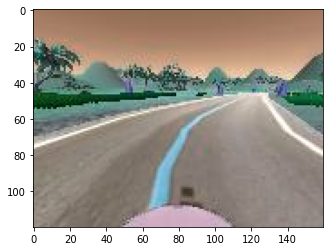

Label:
0.1688311
37/37 [==============================] - 1s 23ms/step - loss: 0.0429 - n_outputs0_loss: 0.0429 - n_outputs1_loss: 8.3169e-07
[[0.05077497]
 [0.05043893]
 [0.04962441]
 ...
 [0.05032755]
 [0.0503633 ]
 [0.0501763 ]]
(2, 4799)
result:
-0.009415135
0.049489528
0.1688488202068041
0.52687999479672
0.47312000520328
Evaluation for Generated Road Data:


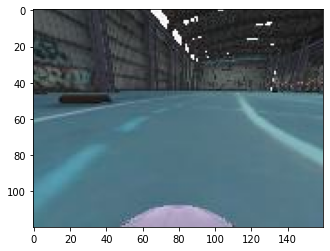

Label:
0.012755325
30/30 [==============================] - 1s 22ms/step - loss: 0.0247 - n_outputs0_loss: 0.0247 - n_outputs1_loss: 1.6062e-07
[[0.0501578 ]
 [0.0501578 ]
 [0.05027103]
 ...
 [0.04986691]
 [0.04978746]
 [0.05008857]]
(2, 3918)
result:
0.0073048207
0.049844537
0.12406707397880078
0.6523599358614851
0.3476400641385149
Model Evaluation for Warehouse Data


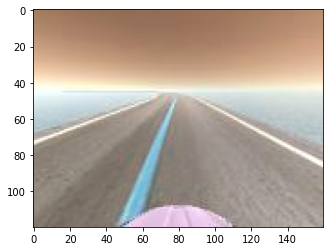

Label:
1.5308085e-16
39/39 [==============================] - 1s 22ms/step - loss: 0.0320 - n_outputs0_loss: 0.0320 - n_outputs1_loss: 8.9965e-07
[[0.05050377]
 [0.05050377]
 [0.050497  ]
 ...
 [0.05045459]
 [0.05036798]
 [0.04933832]]
(2, 5130)
result:
-0.019336108
0.05017793
0.13253299931257592
0.6286381317466532
0.3713618682533468


In [ ]:
modelname = 'DefaultCNN_LIT-186.h5'
BATCH = 132

ModelBest = keras.models.load_model(modelname)

num = randrange(len(x_test0))

#Select Random Image and Label to show as examples
plt.imshow(x_test0[num])
plt.show()

pred_im = x_test0[num]
pred_label = y_testa0[num]

print("Label:")
print(pred_label)

#Model prediction
diff = np.zeros(len(y_testa0))
perc = np.zeros(len(y_testa0))


#label_out = model.predict(x_val, batch_size=BATCH,verbose=1)
label_out = ModelBest.predict(x_test0, batch_size=BATCH,verbose=1)
ModelBest.evaluate(x_test0, [y_testa0, y_testt0], batch_size=BATCH, verbose=1)
print(label_out[1])
label_out = np.asarray(label_out)
label_out=np.squeeze(label_out)
print(label_out.shape)
for i in range(0, len(y_testa0)):
  diff[i] = abs(y_testa0[i] - label_out[0,i])
  perc[i] = (np.max(y_testa0)-diff[i])/np.max(y_testa0)
#model.save('LIT-16.h5')
print("result:")
print(label_out[0,num])
print(label_out[1,num])
print(np.sum(diff)/len(diff))
print(np.sum(perc)/len(perc))
print(1-np.sum(perc)/len(perc))

print("Evaluation for Generated Road Data:")
num = randrange(len(x_test1))

#Select Random Image and Label to show as examples
plt.imshow(x_test1[num])
plt.show()

pred_im = x_test1[num]
pred_label = y_testa1[num]

print("Label:")
print(pred_label)

#Model prediction
diff = np.zeros(len(y_testa1))
perc = np.zeros(len(y_testa1))

label_out = ModelBest.predict(x_test1, batch_size=BATCH,verbose=1)
ModelBest.evaluate(x_test1, [y_testa1, y_testt1], batch_size=BATCH, verbose=1)
print(label_out[1])
label_out = np.asarray(label_out)
label_out=np.squeeze(label_out)
print(label_out.shape)
for i in range(0, len(y_testa1)):
  diff[i] = abs(y_testa1[i] - label_out[0,i])
  perc[i] = (np.max(y_testa1)-diff[i])/np.max(y_testa1)
#model.save('LIT-16.h5')
print("result:")
print(label_out[0,num])
print(label_out[1,num])
print(np.sum(diff)/len(diff))
print(np.sum(perc)/len(perc))
print(1-np.sum(perc)/len(perc))

print("Model Evaluation for Warehouse Data")

num = randrange(len(x_test2))

#Select Random Image and Label to show as examples
plt.imshow(x_test2[num])
plt.show()

pred_im = x_test2[num]
pred_label = y_testa2[num]

print("Label:")
print(pred_label)

#Model prediction
diff = np.zeros(len(y_testa2))
perc = np.zeros(len(y_testa2))


#label_out = model.predict(x_test2, batch_size=BATCH,verbose=1)
label_out = ModelBest.predict(x_test2, batch_size=BATCH,verbose=1)
ModelBest.evaluate(x_test2, [y_testa2, y_testt2], batch_size=BATCH, verbose=1)
print(label_out[1])
label_out = np.asarray(label_out)
label_out=np.squeeze(label_out)
print(label_out.shape)
for i in range(0, len(y_testa2)):
  diff[i] = abs(y_testa2[i] - label_out[0,i])
  perc[i] = (np.max(y_testa2)-diff[i])/np.max(y_testa2)
#model.save('LIT-16.h5')
print("result:")
print(label_out[0,num])
print(label_out[1,num])
print(np.sum(diff)/len(diff))
print(np.sum(perc)/len(perc))
print(1-np.sum(perc)/len(perc))


In [ ]:
#Mountain Pass Data Val
